In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from tueplots import bundles
plt.rcParams.update(bundles.neurips2022())
import numpy as np
import matplotlib.colors as colors
import seaborn as sns

In [3]:
import os

print('Current directory:'.format(os.getcwd()))
# target_dir = '/home/debortoli/research/22-rhmc/Tex'
# os.chdir(target_dir)


Current directory:


In [4]:
N = 1000
xlimleft = 3
xlimright = 4.4
ylimleft = 2.0
ylimright = 2.0
X = np.linspace(-xlimleft, xlimright, N)
Y = np.linspace(-ylimleft, ylimright, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

b = np.array([1, 1, 1, 1, 1, 1, 1])* 2.1
A = np.array([[.5, 1], [-1, 0.4], [0.2, 0.5], [0.25, -1], [.5, 0], [0, 1.2], [-0.2, -1.2]]).T

def barrier(A, b, pos):
    At = A.T
    out = np.zeros(pos.shape[:-1])
    for k in range(len(b)):
        out += -np.log(b[k] - At[k, 0] * pos[:, :, 0] - At[k, 1] * pos[:, :, 1])
    return out


Z = barrier(A, b, pos)
Z_out = Z[np.isnan(Z)==False]
Z_out = Z_out[np.isinf(Z_out)==False]
Z_min = np.min(Z_out)
Z += -Z_min + 1

levels = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 20, 30, 40]
levels = np.linspace(0, 40, 1000)


/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_47327/4095624646.py:22: RuntimeWarning: divide by zero encountered in log
  out += -np.log(b[k] - At[k, 0] * pos[:, :, 0] - At[k, 1] * pos[:, :, 1])
/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_47327/4095624646.py:22: RuntimeWarning: invalid value encountered in log
  out += -np.log(b[k] - At[k, 0] * pos[:, :, 0] - At[k, 1] * pos[:, :, 1])


In [5]:
font = {'family' : 'serif',
        'serif'  : ['Times New Roman'],
        # 'weight' : 'bold',
        'size'   : 9
        }

mathtext = {"rm"  : "serif",
            "it"  : "serif:italic",
            "bf"  : "serif:bold",
            "fontset": "custom",
}

mpl.rc('font', **font)
# mpl.rc('mathtext', **mathtext)
mpl.rc('text', usetex='true')
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amsfonts}')

import seaborn as sns
import pandas as pd

# sns.set_palette(
#     "husl", 3, desat=1
# )

lw = 3.25063
pw = 6.75133

In [62]:
import os
os.environ["GEOMSTATS_BACKEND"] = "autograd"
import numpy as np
import geomstats.backend as gs
from autograd.numpy import diag

from geomstats.geometry.riemannian_metric import RiemannianMetric
from geomstats.integrator import integrate

class HessianPolytopeMetric(RiemannianMetric):
    def __init__(self, T, b, eps=1e-6, default_point_type="vector", **kwargs):
        self.T, self.b = T, b
        self.eps = eps
        dim = self.T.shape[1]
        super(HessianPolytopeMetric, self).__init__(
            dim=dim, default_point_type=default_point_type
        )

    def metric_matrix(self, x):
        res = gs.maximum(self.b - self.T @ x.T, 0) + self.eps
        return self.T.T @ diag(res**-2) @ self.T

    def cometric_matrix(self, x):
        u, s, v = gs.linalg.svd(self.metric_matrix(x), hermitian=True)
        return u @ diag(s**-1) @ v

    
    def flow(
        self,
        tangent_vec,
        base_point,
        n_steps,
        step="euler",
        point_type=None,
        **kwargs
    ):
        
        initial_state = gs.stack([base_point, tangent_vec])
        flow = integrate(
            self.geodesic_equation, initial_state, n_steps=n_steps, step=step
        )

        return flow

metric = HessianPolytopeMetric(A.T, b)
base_point = np.array([2.0, 0.])
tangent_vec = np.array([0., 1.])
flow = metric.flow(5 * tangent_vec, base_point, n_steps=1000, step="rk4")
flow = np.stack(list(map(lambda x: x[0], flow)), axis=0)

In [109]:
import jax
import jax.numpy as jnp
from diffrax.misc import bounded_while_loop
import cvxpy as cp
import jax.experimental.host_callback as hcb
import geomstats.backend as gs

diagm = jax.vmap(jnp.diag)

def proj(inp):
    A, b, base_point = inp
    X = cp.Variable(base_point.shape)
    problem = cp.Problem(
        cp.Minimize(cp.sum_squares(X - base_point)),
        [A @ X.T <= b[:, None]]
    )
    problem.solve()
    return X.value

def device_proj(A, b, x):
    return hcb.call(
        proj, (A, b, x),
        result_shape=jax.ShapeDtypeStruct(x.shape, x.dtype)
    )

def stable_div(num, den, eps=1e-10):
    return (
        jnp.sign(num)
        * jnp.sign(den)
        * jnp.exp(jnp.log(jnp.abs(num) + eps) - jnp.log(jnp.abs(den) + eps))
    )

def bounded_step(
        base_point, step_dir, step_mag, A, b,
        eps=1e-6, eps2=1e-8, max_val=1e10
):
    step_size_mask = step_mag > 0
    num, den = A @ base_point.T - b[:, None], A @ step_dir.T
    scale = -stable_div(num, den) * step_size_mask
    scale = jnp.clip(scale, -max_val, max_val)
    # we are moving in the "positive" direction
    # of s here, so mask out negative values
    scale_mask = scale <= 0
    masked_scale = scale_mask * max_val + (1 - scale_mask) * scale
    # compute the face we will hit first,
    # e.g. the minimum scaling that lands us
    # on a face
    step_mag_argmax = masked_scale.argmin(axis=0)
    step_mag_max = scale[step_mag_argmax, jnp.arange(scale.shape[1])]
    # us either the remaining magnitude sr
    # or the maximum scaling that lands us
    # on a face to scale in the direction s
    # add this to values of rp which we still
    # have magnitude left in their step length
    step_mag = jnp.maximum(jnp.minimum(step_mag, step_mag_max), 0)
    base_point = base_point + step_mag[:, None] * step_dir
    diff = A @ base_point.T - b[:, None]
    idx = diff >= -eps2
    base_point = base_point + (A.T @ (-(jnp.abs(diff) + eps) * idx)).T
    return base_point, step_mag, step_mag_argmax

def reflect(
        base_point, step, A, b,
        eps=1e-6, eps2=1e-8, max_val=1e10, max_iter=100_000
):
    """
    Given a set of N vectors rp in a d-polytope compute the
    set of steps rp + s, where we reflect in the direction
    normal to the face whenever we would hit a face.
    This allows computing a reflected brownian motion in
    a polytope.
    rp : ndarray : (N, d)
        the set of initial positions
    s : ndarray : (N, d)
        the set of steps to take
    T : ndarray : (M, d) and b : ndarray : M
        the matrix/vector defining the polytope by the
        inequality constraint: T x <= b
    """

    # normalize z to a direction and a
    # magnitude; we will use the magnitudes
    # here to continue reflecting until we
    # have traveled the whole distance
    def reflect_cond(val):
        _, _, _, _, remaining_step_mag = val
        return jnp.any(remaining_step_mag > 0)

    def reflect_body(val, _):
    # def reflect_body(val):
        # compute the amount we can scale in the
        # direction s before hitting any face,
        # for any of the rp, s vector pairs
        i, traj, base_point, step_dir, remaining_step_mag = val
        base_point, step_mag, step_mag_argmax = bounded_step(
            base_point, step_dir, remaining_step_mag, A, b, eps=eps, eps2=eps2, max_val=max_val
        )
        traj = traj.at[i, ...].set(base_point)
        i += 1
        # we are going to reflect around the face
        # we land on, so we grab that face from T
        # and normalize it
        normal_face = A[step_mag_argmax, :]
        normal_face = normal_face / jnp.sqrt(jnp.sum(normal_face**2, axis=-1))[:, None]
        # this is the reflection: note we only
        # need to reflect the direction vector s
        # about the face. for a single vector
        # and a single face we can do that using
        # this eqn: r = s - 2 * dot(s, n) * n
        # where r is the reflection. for the
        # vectorized case we compute the row-wise
        # dot products using jnp.sum(s * n, axis=-1)
        step_dir = step_dir - (2 * jnp.sum(step_dir * normal_face, axis=-1)[:, None] * normal_face)
        # because n and s are normalized the
        # resulting s should be normalized too
        # we renormalize for numberical stabilty
        step_dir = step_dir / jnp.sqrt(jnp.sum(step_dir**2, axis=-1))[:, None]
        # now we subtract the distance we
        # reflected from the magnitude, once this
        # is negative we stop reflecting that
        # vector
        remaining_step_size = remaining_step_mag - step_mag
        return i, traj, base_point, step_dir, remaining_step_size

    step_mag = jnp.sqrt(jnp.sum(step**2, axis=-1))
    step_dir = step / step_mag[:, None]
    traj = jnp.zeros((max_iter, *base_point.shape))
    i, traj, base_point, _, _ = bounded_while_loop(
        reflect_cond, reflect_body, (0, traj, base_point, step_dir, step_mag), max_iter
    )
  
    return traj[:i]


def reflected_flow(tangent_vec, base_point, n_steps):
    res = reflect(base_point, tangent_vec, jnp.array(A.T), jnp.array(b), max_iter=100)
    res = res.squeeze(1)
    res = jnp.concatenate([base_point, res], axis=0)
    K = res.shape[0]
    dists = jnp.zeros((K))
    for k in range(1, K):
        dists = dists.at[k].set(jnp.linalg.norm(res[k] - res[k-1]))
    prop = dists / jnp.sum(dists)
    flow = []
    for k in range(1, K):
        t = jnp.linspace(0, 1, int(prop[k] * n_steps), endpoint=True)[:, None]
        traj_k = (1 - t) * res[k-1][None, :] + t * res[k][None, :]
        flow.append(traj_k)
    flow = jnp.concatenate(flow, axis=0)
    print("prop", prop)
    return flow

flow2 = reflected_flow(5 * jnp.array(tangent_vec)[None,...], jnp.array(base_point)[None,...], n_steps=1000)
print("base_point", base_point)
print("flow", flow2.shape)

t = jnp.linspace(0, 1, 1000, endpoint=True)[:, None]
flow3 = base_point[None, :] + t * 5 * tangent_vec[None, :]

prop [0.         0.21999983 0.78000015]
base_point [2. 0.]
flow (999, 2)


/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_47327/3988418593.py:78: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default

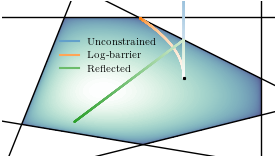

In [123]:
import scipy.linalg

def g(x):
    return A @ np.diag((A.T @ x - b)**(-2)) @ A.T

x0 = np.array([0,1.7])

def ellipse(x0, g, n=100):
    t = np.linspace(0, 2*np.pi, n)
    u = np.array([np.cos(t), np.sin(t)]) * 0.8
    out = x0.reshape(-1,1) + scipy.linalg.sqrtm(np.linalg.inv(g(x0))) @ u
    return out

fig = plt.figure(figsize=(lw, lw/2))
ax = fig.add_subplot(1, 1, 1)

delta = 0.2
x = np.linspace(-xlimleft - delta, xlimright + delta, N)
colours = sns.color_palette("crest", len(b))
# pos = 
for i in range(len(b)):
    label = fr'$f_{i}$'
    # colour = colours[i]
    colour = 'black'
    if A.T[i, 1] != 0:
        y = -A.T[i, 0] / A.T[i, 1] * x + b[i] / A.T[i, 1]
        # label = fr'${A.T[i, 1]} y < {b[i]} - {A.T[i, 0]} x$'
        ax.plot(x, y, color = colour, lw=1.,zorder=0)
    else:
        # label = fr'$x < {b[i]/A.T[i, 0]}$'
        ax.axvline(x=b[i]/A.T[i, 0], color = colour, lw=1.,zorder=0)


# cmap = sns.color_palette("crest", as_cmap=True)
cmap = sns.cubehelix_palette(start=.5, rot=-.5, light=1.,dark=0.,  as_cmap=True)
# cmap = sns.cubehelix_palette(start=-.2, rot=.6, light=1.,dark=0.,  as_cmap=True)
# cmap = sns.cubehelix_palette(start=.5, rot=-.75, light=1.,dark=0.,  as_cmap=True)

ax.contourf(X, Y, Z, levels=levels, norm=colors.LogNorm(vmin=1, vmax=45), cmap=cmap, zorder=-1)
# ax.contourf(X, Y, Z, levels=levels, norm=colors.PowerNorm(gamma=.2, vmin=1, vmax=50), cmap=cmap)
# ax.contourf(X, Y, Z, levels=100, cmap=cmap, vmin=1, vmax=100)

# plot geodesics
# cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
cmap = mpl.colors.LinearSegmentedColormap.from_list('blend', ('white', 'tab:blue'), gamma=1.0)
ax.scatter(flow3[:, 0], flow3[:, 1], s=0.25, cmap=cmap, c=np.linspace(0,1,flow3.shape[0]))
ax.plot([], [], color=cmap(0.7), label="Unconstrained")
cmap = mpl.colors.LinearSegmentedColormap.from_list('blend', ('white', 'tab:orange'), gamma=1.0)
ax.scatter(flow[:, 0], flow[:, 1], s=0.25, cmap=cmap, c=np.linspace(0,1,flow.shape[0]))
ax.plot([],[], color=cmap(0.7), label="Log-barrier")
cmap = mpl.colors.LinearSegmentedColormap.from_list('blend', ('white', 'tab:green'), gamma=1.0)
ax.scatter(flow2[:, 0], flow2[:, 1], s=0.25, cmap=cmap, c=np.linspace(0,1,flow2.shape[0]))
ax.plot([], [], color=cmap(0.7), label="Reflected")

k = 10
U = flow[1:, 0]-flow[:-1, 0]
V = flow[1:, 1]-flow[:-1, 1]
# U = U / np.sqrt(U**2 + V**2)
# V = V / np.sqrt(U**2 + V**2)
# ax.quiver(flow[:-1, 0][::k], flow[:-1, 1][::k], U[::k], V[::k], scale_units='xy', angles='xy', scale=1/10, width=0.003, headwidth=3/1, headlength=5/1, headaxislength=4.5/1) 
ax.scatter(base_point[0], base_point[1], s=2., c='black', marker="X")
# ax.arrow(base_point[0], base_point[1], tangent_vec[0], tangent_vec[1], width=0.001)

# x0_list = [np.array([0, 1.5]), np.array([1, 0]), np.array([3.85, -.5])]
# for x0 in x0_list:
#     out = ellipse(x0, g)
#     ax.plot(out[0], out[1], color='white', linewidth=1., alpha=1.)
#     ax.plot(x0[0], x0[1], 'o', color='white', markersize=1., alpha=1.)

ax.grid(False)
# ax.set_axisbelow(True)
ax.axis('off')
ax.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.39,.82))
ax.set_xlim((-xlimleft - delta, xlimright + delta))
ax.set_ylim((-ylimleft - delta, ylimright + delta))
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.savefig("polytope.png", dpi=300, bbox_inches='tight',
            pad_inches=0, transparent=True)


In [119]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('blend', ('white', 'tab:green'), gamma=1.0)

(0.5846520569011919, 0.8129950019223375, 0.5846520569011919, 1.0)